# King County Housing Analysis

---

**Import Necessary Libraries**

In [1]:
#data cleaning and stats
import pandas as pd
import numpy as np

#plotting
import seaborn as sns
import matplotlib.pyplot as plt

#normality check
import scipy.stats as stats

#data transformation
from sklearn import preprocessing

#multiple linear regression
import statsmodels.api as sm
from statsmodels.formula.api import ols

#model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from math import sqrt

In [2]:
#read data
df = pd.read_csv('data/kingcounty.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


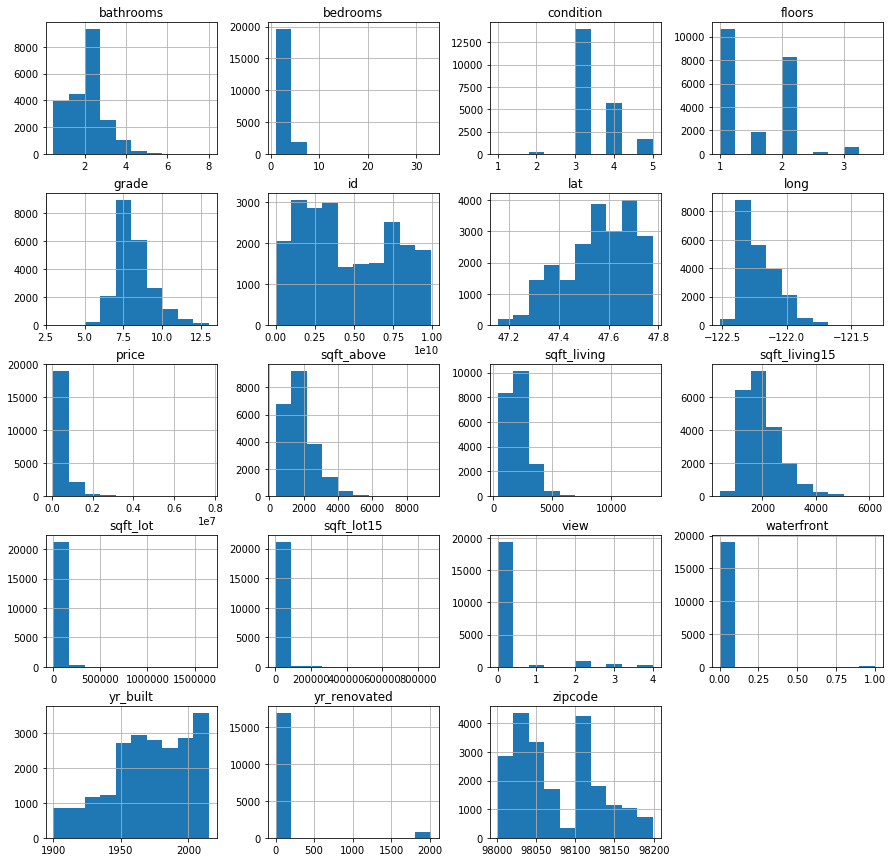

In [4]:
df.hist(figsize=(15,15));

---

## Data Cleaning

In [5]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [6]:
# waterfront, view, and yr_renovated have null values
# will look into that deeper to decide how to deal with them
# yr_renovated has a lot of missing values represented with a placeholder

In [7]:
# replace NaNs with 0
df['yr_renovated'] = df['yr_renovated'].fillna(0)

In [8]:
# make column renovated categorical, 1=renovated 0=not renovated
#drop yr_renovated column
df['renovated']=df['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)
df = df.drop(['yr_renovated'], axis=1)

In [9]:
df['renovated'].value_counts()

0    20853
1      744
Name: renovated, dtype: int64

In [10]:
# replace NaN values in "waterfront" with 0
df['waterfront'] = df['waterfront'].fillna(0)

In [11]:
# I will replace NaN values in "view" with 0
df['view'] = df['view'].fillna(0)

In [12]:
#one last check for NaN values
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
renovated        0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
renovated        21597 non-null int64
dtypes: float64(7), int64(12), object(2)
memory usage: 3.5+ MB


In [14]:
df.sqft_basement.value_counts().head()

0.0      12826
?          454
600.0      217
500.0      209
700.0      208
Name: sqft_basement, dtype: int64

In [15]:
#replaced '?' values with difference in sqft_living and sqft_above
df.loc[df['sqft_basement'] == '?', 'sqft_basement'] = df['sqft_living'] - df['sqft_above']

In [16]:
#deal with object types in order to plot heatmap
df['sqft_basement'] = df['sqft_basement'].apply(lambda x: float(x))

In [17]:
#drop 'id' and 'date' column because it is not a predictor
#drop lat and long 
df = df.drop(df[['id', 'date', 'lat', 'long']], axis=1)

In [18]:
#change yr_built column to age of house column
df['age'] = df['yr_built'].apply(lambda x: 2019 - x)
df = df.drop(['yr_built'], axis=1)

In [19]:
#transform categorical column 'renovated'
renovated_dummies = pd.get_dummies(df["renovated"], 
                                   prefix="renovated", 
                                   drop_first=True,
                                  dtype=int)
df = df.drop(["renovated"], axis=1)
df = pd.concat([df, renovated_dummies], axis=1)

In [20]:
#transform categorical column 'waterfront'
waterfront_dummies = pd.get_dummies(df["waterfront"], 
                                    prefix="waterfront", 
                                    drop_first=True,
                                   dtype=int)
df = df.drop(["waterfront"], axis=1)
df = pd.concat([df, waterfront_dummies], axis=1)

In [21]:
# #convert 'floors' to int
# df['floors'] = df['floors'].apply(lambda x: int(x))
# df['view'] = df['view'].apply(lambda x: int(x))
# df['sqft_basement'] = df['sqft_basement'].apply(lambda x: int(x))

---

## Correlation Visualization

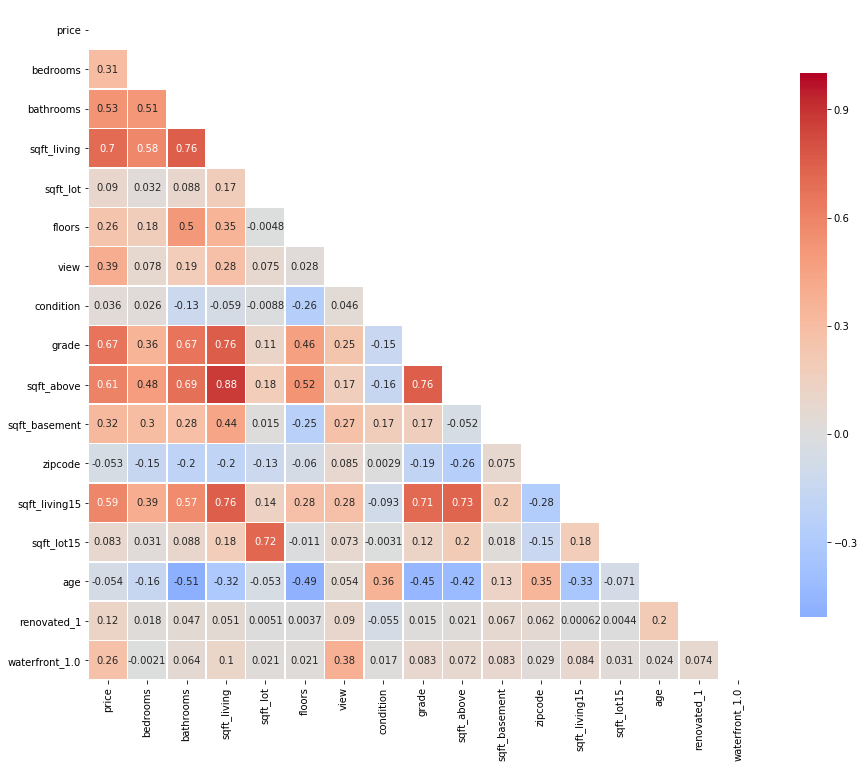

In [22]:
#visualize correlation using heatmap
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 20))

sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5,annot=True, cbar_kws={"shrink": .5});

In [23]:
# I will start with all variables positively correlated with target variable

df_1 = df.drop(df[['zipcode', 'age']], axis=1)

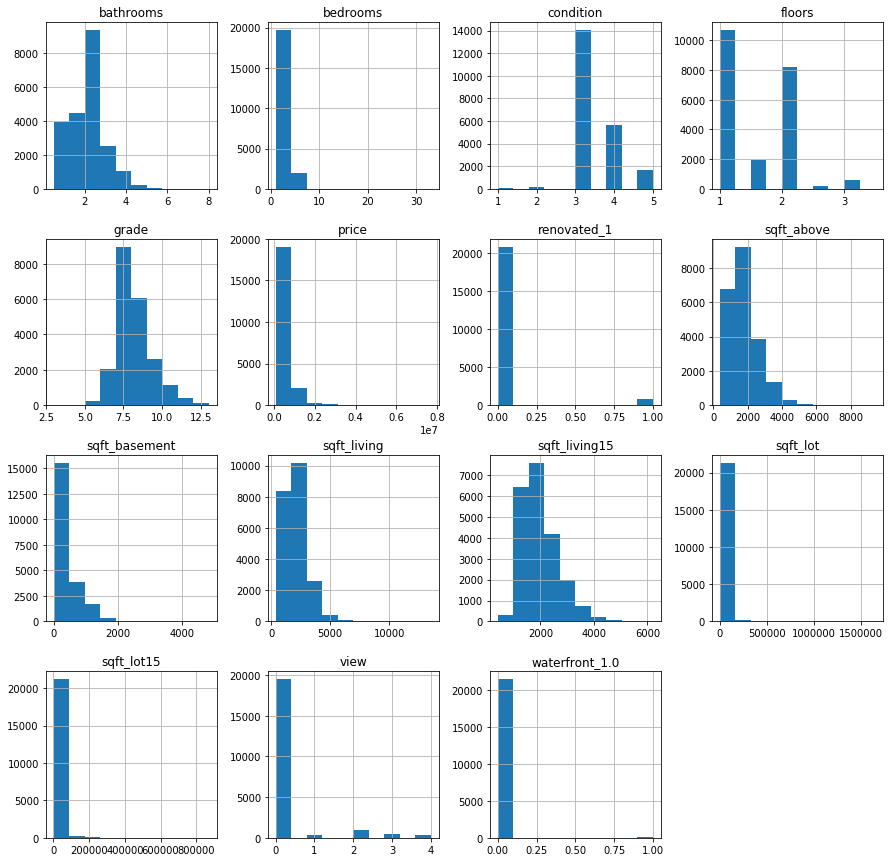

In [24]:
#let's take a look of distributions of selected predictors after preliminary data cleaning
df_1.hist(figsize=(15,15));

**Looks like there is skewness and variance in magnitude of the independent variables.** <br/>

---

## Linear Regression Assumption checks <br/>
1. Linearity 
2. Normality (residuals) - will check with residuals
3. Homoscedasticity

In [25]:
df_1.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'view', 'condition', 'grade', 'sqft_above', 'sqft_basement',
       'sqft_living15', 'sqft_lot15', 'renovated_1', 'waterfront_1.0'],
      dtype='object')

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


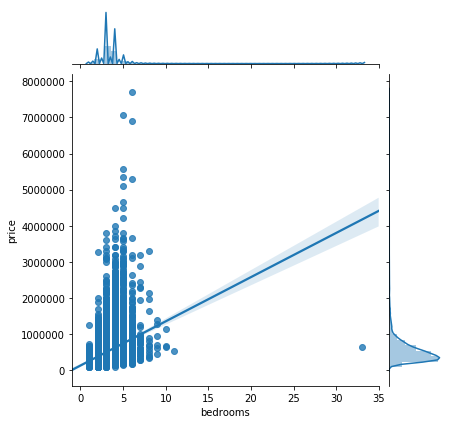

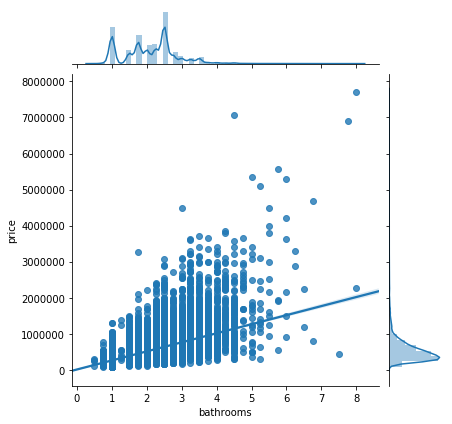

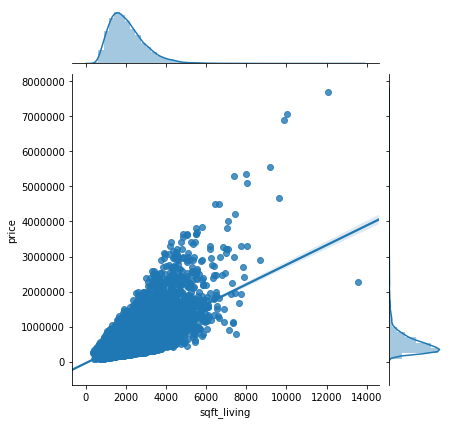

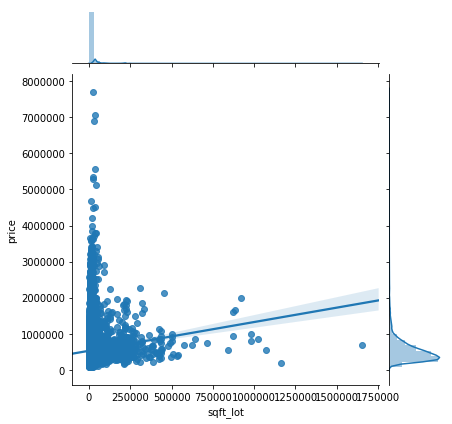

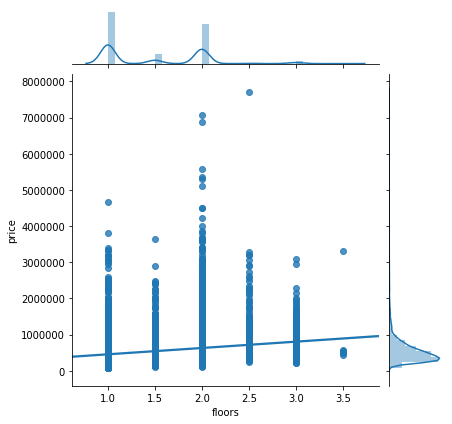

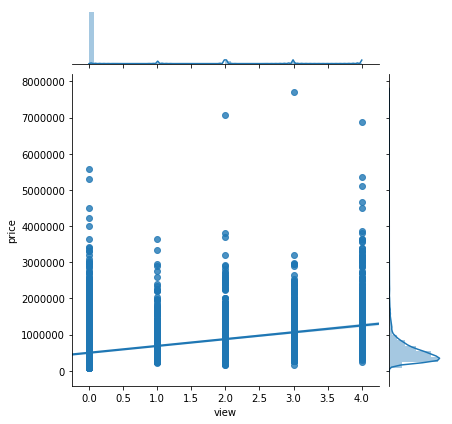

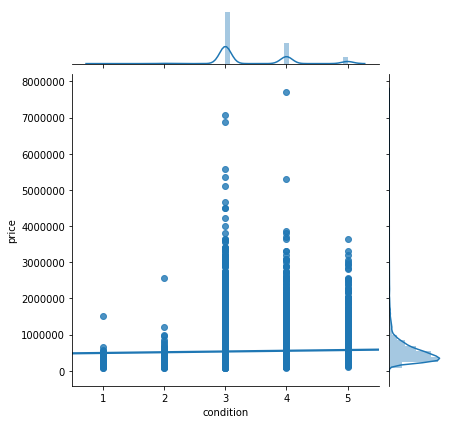

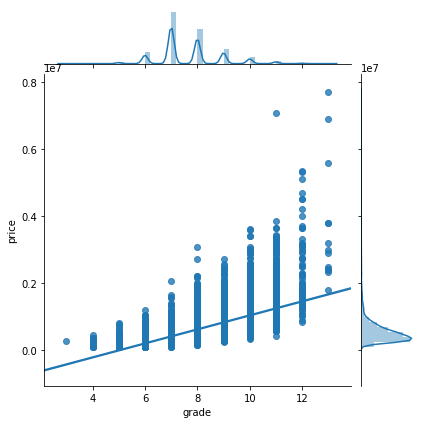

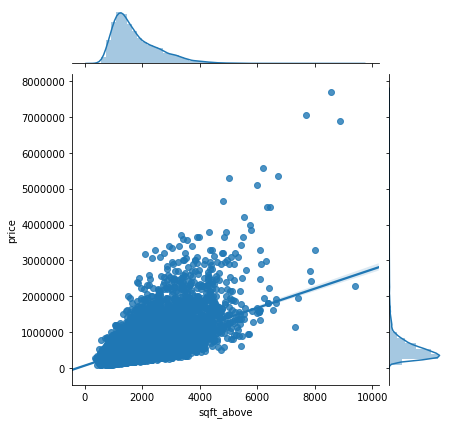

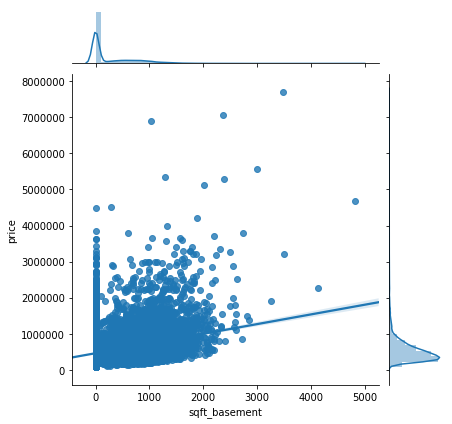

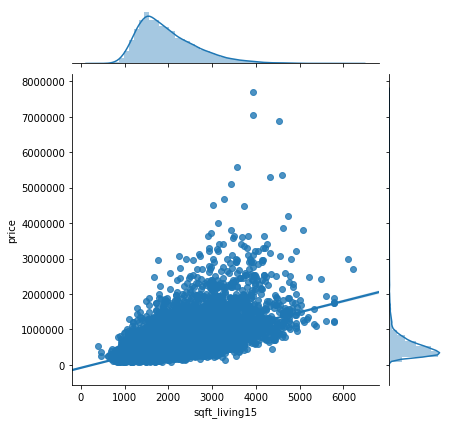

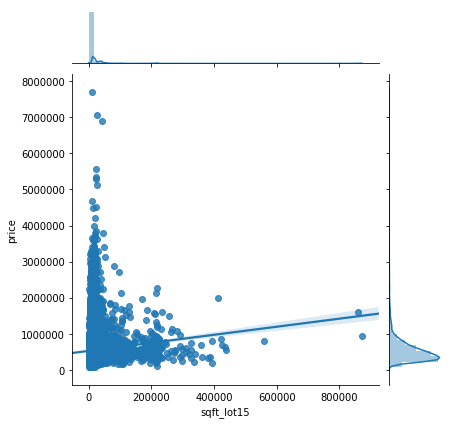

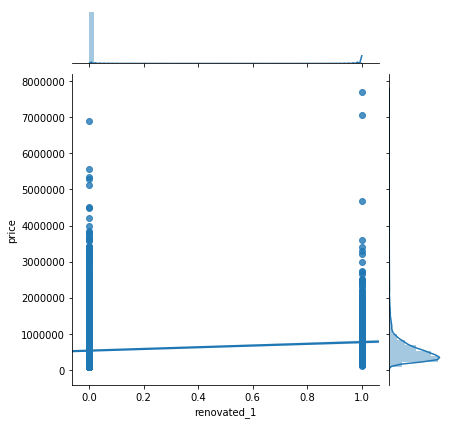

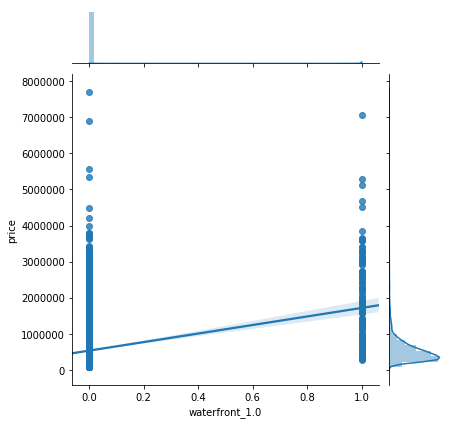

In [26]:
#Using joint plots to check linearity and homoscedasticity
#will check normality of residuals after building model


#plotting selected variables
for col in df_1.drop('price', axis=1):
    sns.jointplot(col,'price',data=df,kind='reg')
    plt.show()

---

## Initial Multiple Linear Regression Model

In [27]:
predictors = df_1[['bathrooms', 'bedrooms', 'sqft_living',
                    'sqft_lot', 'sqft_living15', 'sqft_lot15',
                    'grade', 'waterfront_1.0', 'renovated_1', 
                    'sqft_basement', 'floors', 'view',
                  'sqft_above', 'condition']]

In [28]:
target = df['price']

predictors_int = sm.add_constant(predictors)
model = sm.OLS(target, predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     2626.
Date:                Mon, 02 Sep 2019   Prob (F-statistic):               0.00
Time:                        17:39:09   Log-Likelihood:            -2.9715e+05
No. Observations:               21597   AIC:                         5.943e+05
Df Residuals:                   21583   BIC:                         5.944e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -7.191e+05   1.74e+04    -41.319      0.000   -7.53e+05   -6.85e+05
bathrooms      -1.633e+04   3471.320     -4.705      0.000   -2.31e+04   -9528.023
bedrooms        -3.46e+04   2152.003    -16.077      0.000   -3.88e+04   -3.04e+04
sqft_living      131.4968      2.542     51.723      0.000     126.514     136.480
sqft_lot           0.0301      0.054      0.555      0.579      -0.076       0.136
sqft_living15     14.4039      3.807      3.784      0.000       6.942      21.866
sqft_lot15        -0.7614      0.083     -9.185      0.000      -0.924      -0.599
grade           1.026e+05   2359.402     43.488      0.000     9.8e+04    1.07e+05
waterfront_1.0  6.041e+05   2.06e+04     29.322      0.000    5.64e+05    6.44e+05
renovated_1     1.512e+05   8625.031     17.536      0.000    1.34e+05    1.68e+05
sqft_basement     79.6006      2.909     27.363      0.000      73.899      85.303
floors         -1781.5205   3965.265     -0.449      0.653   -9553.733    5990.692
view            5.792e+04   2366.599     24.474      0.000    5.33e+04    6.26e+04
sqft_above        51.8962      2.494     20.807      0.000      47.007      56.785
condition       5.743e+04   2519.978     22.790      0.000    5.25e+04    6.24e+04
==============================================================================
Omnibus:                    15662.171   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           936129.413
Skew:                           2.902   Prob(JB):                         0.00
Kurtosis:                      34.727   Cond. No.                     2.58e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.3e-20. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**Normality check (Model Residuals)**

/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


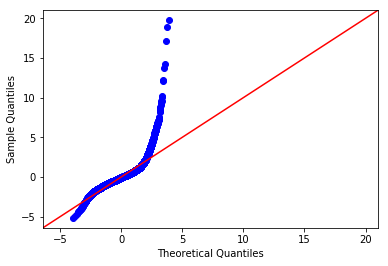

In [29]:
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

**Looks like there is a deviation, need to look into further**

**Check the metrics for initial model**

In [30]:
def rmse(y_actual,y_predicted):
    """Return RootMeanSquared Error"""
    return sqrt(mean_squared_error(y_actual, y_predicted))


def mae(y_actual,y_predicted):
    """Return MeanSquared Erros"""
    return abs(y_actual-y_predicted).mean()

In [31]:
X = df['price']
y = predictors.values

In [32]:
model = LinearRegression()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 8)

In [34]:
model.fit(X_train, y_train)

ValueError: Expected 2D array, got 1D array instead:
array=[ 646800.  314000.  280000. ...  150000. 1730000.  412000.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
y_pred = model.predict(X_test)
print(rmse(y_test,y_pred))
print(mae(y_test,y_pred))

---

In [ ]:
#next steps
#look into normality check deviation
##remove independent variables with p-value above of 0.05 ('sqft_lot' and 'floors')
##remove independent variables that are highly correlated with each other

---

## Multicollinearity Check

**Correlation with an absolute value around 0.7-0.8 or higher is considered a high correlation. <br/>
I will remove independant variables that are highly correlated with each other.**

In [ ]:
df_1.corr()

In [ ]:
#check to see which independant variables have corraletion greater than 0.8
abs(df_1.corr()) > 0.8

**Independant Variables Highly Correlated with each other** <br/>
sqft_living - sqft_above <br/>
sqft_above - sqft_living <br/>

**I will drop 'sqft_above' because 'sqft_living' is has a higher correlation to the target variable.**

---

## Second Multiple Linear Regression Model

In [ ]:
new_predictors = df_1[['bathrooms', 'bedrooms', 'sqft_living',
                    'sqft_living15', 'sqft_lot15', 'grade', 
                    'waterfront_1.0', 'renovated_1', 'sqft_basement', 
                    'view', 'condition']]

In [ ]:
target = df['price']

predictors_int = sm.add_constant(new_predictors)
model = sm.OLS(target, predictors_int).fit()
model.summary()

---

In [ ]:
#next steps
#try log transformations
#min-max scale independent variables with high magnitudes
#create dummy variables for columns with few value counts
#check metrics for both models

---

## Log Transformation

In [ ]:
new_predictors.columns

In [ ]:
df_log = pd.DataFrame([])
df_log['bathrooms'] = np.log(df_1['bathrooms'])
df_log['bedrooms'] = np.log(df_1['bedrooms'])
df_log['sqft_living'] = np.log(df_1['sqft_living'])
df_log['sqft_living15'] = np.log(df_1['sqft_living15'])
df_log['sqft_lot15'] = np.log(df_1['sqft_lot15'])

#
df_log['grade'] = df_1['grade']
df_log['waterfront_1'] = df_1['waterfront_1.0']
df_log['renovated_1'] = df_1['renovated_1']
df_log['sqft_basement'] = df_1['sqft_basement']
df_log['view'] = df_1['view']

In [ ]:
df_log.hist(figsize=(15,15));